# Chloe Ting Data Analysis

Data collected using `data-collection-chrome-extension` were exported to CSV file.
This data is from https://www.youtube.com/watch?v=2pLT-olgUJs

This is a comprehensive analysis for choosing features to train a neural network. A full (warning, very long) data exploration helped visualizing how each feature is changing through out the workout video. It can be found at `Chloe Ting Data Exploration`.

## Set up plot function for feature that has array values

Each plot corresponds to the index of the array. Eg. First subplot of MFCC corresponds to first MFCC coeffient.

Area shaded in pink shows when Chloe is speaking. Non-shaded area is when background music is playing.

In [12]:
from CONSTANTS import CLASS_NAMES, CLASS_TO_INT, FEATURES
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

csv_filepath = './data/2020-07-26_06-35-07-unfiltered.csv'
df = pd.read_csv(csv_filepath, sep=',', header=0)

# Get dataframes for time and label
time = df['timestamp'] 
label = df['class']

def get_padding(min_val, max_val):
    return abs(min_val - max_val) * 0.05

def plotFeatureArray(sub_part, divide_factor, start, end, feature_name):
    time_split = np.array_split(time, divide_factor)
    label_split = np.array_split(label, divide_factor)
    sample = []
    
    for i in range(start, end + 1, 1):
        sample.append(df[feature_name + '_' + str(i)])

    n_plots = end - start + 1
    fig, ax = plt.subplots(n_plots, 1, figsize=(15, n_plots * 4))

    # Hack to turn single plot axis into numpy array similar to when having many plots
    if not isinstance(ax, np.ndarray):
        ax = [ax]

    for i in range(len(sample)):
        # Divide sample into smaller chunks
        sample_split = np.array_split(sample[i], divide_factor)

        min_val = np.amin(sample_split[sub_part - 1])
        max_val = np.amax(sample_split[sub_part - 1])
        padding = get_padding(min_val, max_val)
        ylim = [ min_val - padding, max_val + padding]

        ax[i].set_ylim(ylim)
        ax[i].set_title(feature_name + '_' + str(start + i))
        ax[i].plot(time_split[sub_part - 1], sample_split[sub_part - 1])
        ax[i].fill_between(
            time_split[sub_part - 1],
            ylim[0], ylim[1],
            where=label_split[sub_part - 1] == CLASS_TO_INT[CLASS_NAMES['CHLOE']],
            color='lightcoral', alpha=0.2)

    # Show plot
    plt.show()

## Power Spectrum

Power spectrum is the square of the values calculated from FFT. It represents amplitude squared in each frequency bins. 

Chrome extension is used to collect audio data from Youtube video. On my machine, WebAPI AudioContext's sampling rate is `48000 Hz`. The algorithm is aiming to get about 25ms per frame of calculation, hence, ~1024 bytes of buffer size is needed. When performing FFT, maximum output frequency will be half the sampling rate. The output will be array of frequency bins. The size of array will be half of the number of buffer size. For more information, please take a look at directory `data-collection-chrome-extension` README.

### Audio parameters

- Sampling rate: `48000 Hz`.
- Max frequency after FFT: `24000 Hz`
- Buffer size: `1024`
- \# of frequency bins: `512 bins`
- Frequency per bin: `24000/512 = 46.875 Hz`

### Observations

- Bin 1 (`powerSpectrum_1`) roughly contains amplitude of frequency 0~47Hz, bin 2 contains 47~94Hz, and so on
- Bin 1-4 should corresponds to lower frequency of the music such as bass or subs, we Chloe is speaking, the volumn of the music decreases, hence the flat value near 0 in the shaded region

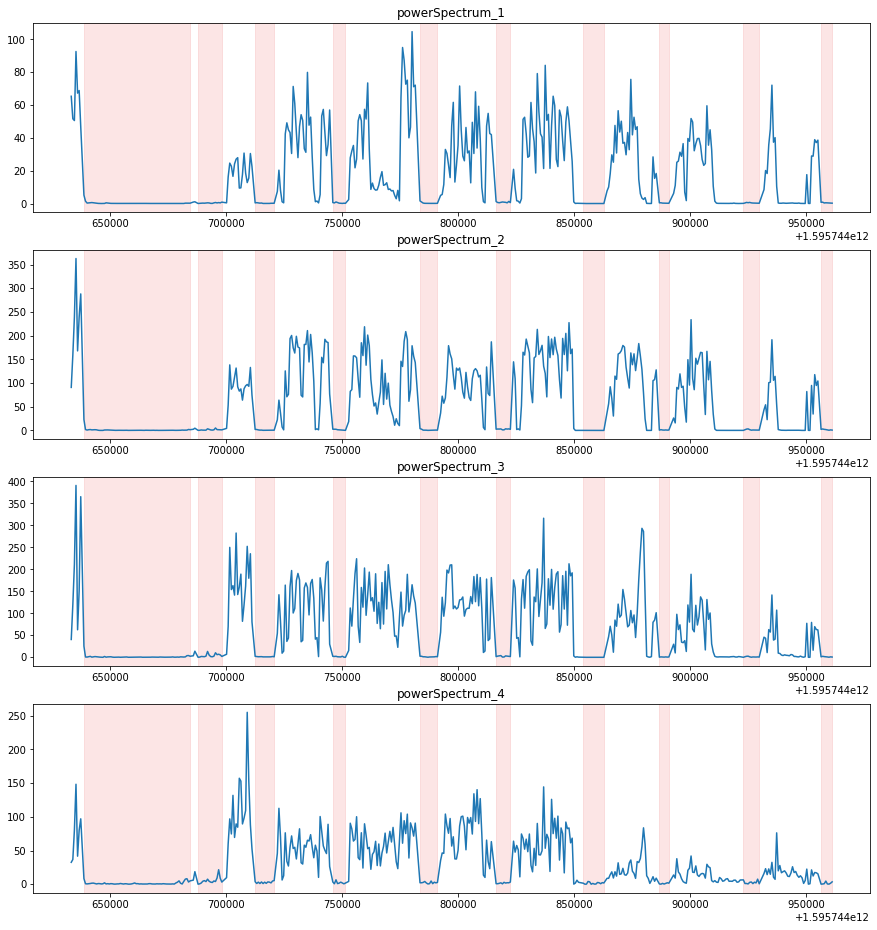

In [13]:
PS_DIVIDE_FACTOR = 2
PS_PART = 1
start_bin = 1
end_bin = 4

plotFeatureArray(PS_PART, PS_DIVIDE_FACTOR, start_bin, end_bin, FEATURES['POWER_SPECTRUM'])

### ~500Hz

- Might be useful to track those peaks when Chloe is speaking, not quite sure what exactly is peaking at 500Hz, maybe some part of vocal, if that's even possible?

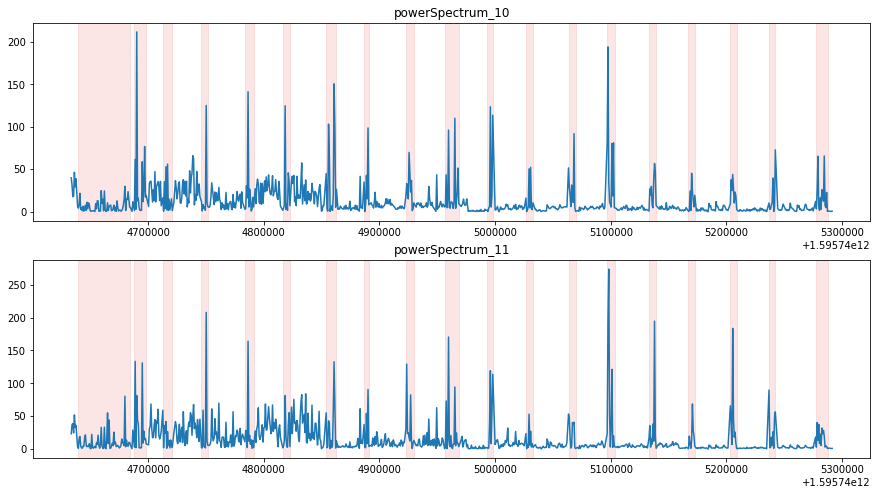

In [14]:
PS_DIVIDE_FACTOR = 1
PS_PART = 1
start_bin = 10
end_bin = 11

plotFeatureArray(PS_PART, PS_DIVIDE_FACTOR, start_bin, end_bin, FEATURES['POWER_SPECTRUM'])

### Beep from Timer

- Beeps are around `1000Hz`, which corresponds to bin 22 to 23
- The last higher pitch beep is around `2000Hz`, which best represented by bin 43 to 45

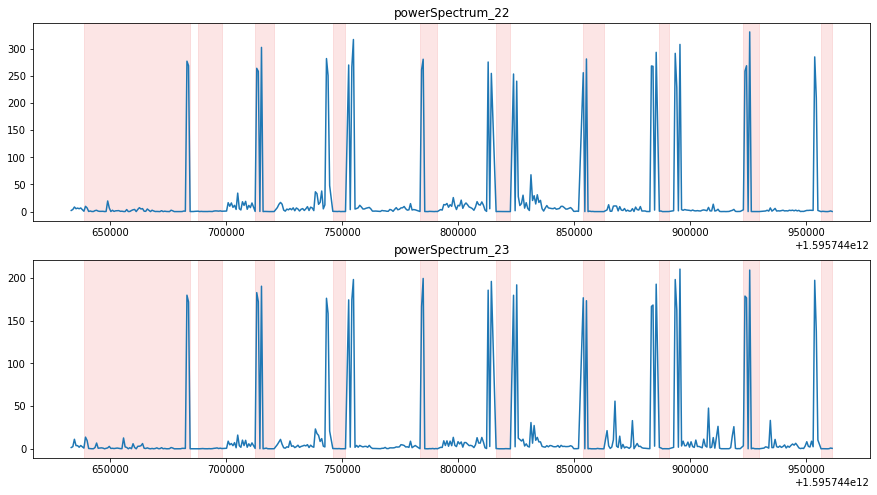

In [15]:
PS_DIVIDE_FACTOR = 2
PS_PART = 1
start_bin = 22
end_bin = 23

plotFeatureArray(PS_PART, PS_DIVIDE_FACTOR, start_bin, end_bin, FEATURES['POWER_SPECTRUM'])

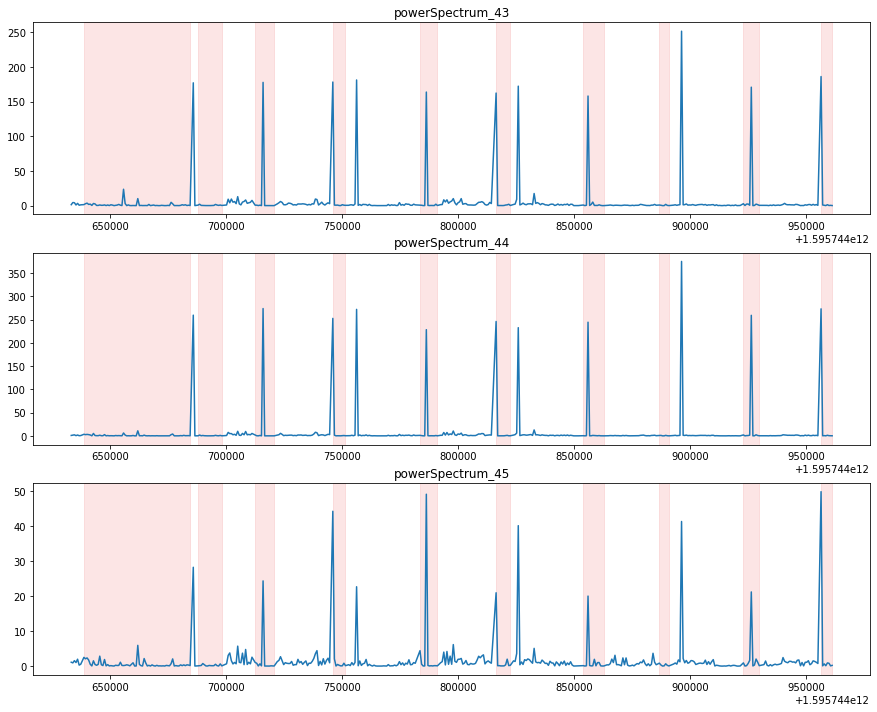

In [16]:
PS_DIVIDE_FACTOR = 2
PS_PART = 1
start_bin = 43
end_bin = 45

plotFeatureArray(PS_PART, PS_DIVIDE_FACTOR, start_bin, end_bin, FEATURES['POWER_SPECTRUM'])

### Other bins

From this training video, bin 109, 110, 125, and 126 seems to have balance distinctions between background music and Chloe's speaking. It might be good to include these to help with the training. This should be mid to higher frequency bands of the music.

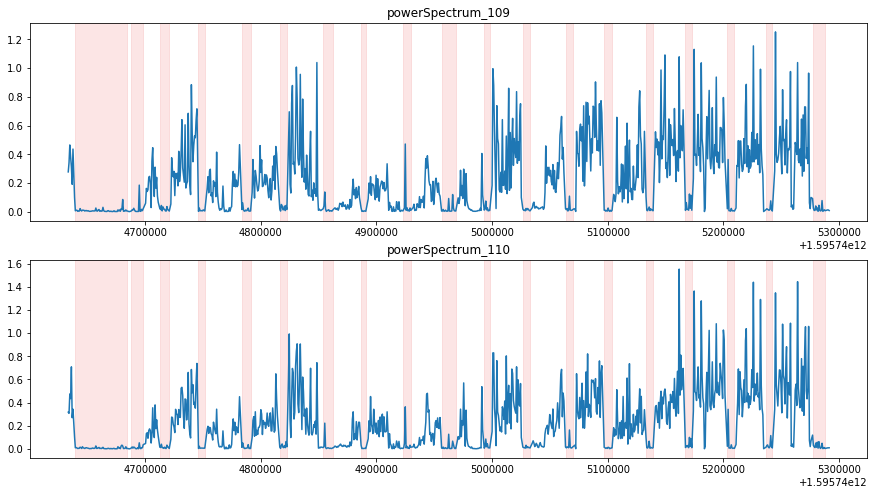

In [17]:
PS_DIVIDE_FACTOR = 1
PS_PART = 1
start_bin = 109
end_bin = 110

plotFeatureArray(PS_PART, PS_DIVIDE_FACTOR, start_bin, end_bin, FEATURES['POWER_SPECTRUM'])

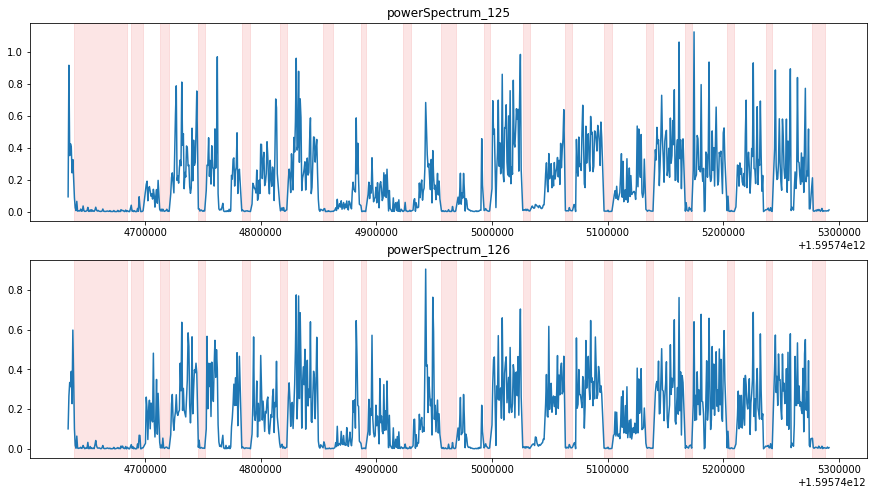

In [18]:
PS_DIVIDE_FACTOR = 1
PS_PART = 1
start_bin = 125
end_bin = 126

plotFeatureArray(PS_PART, PS_DIVIDE_FACTOR, start_bin, end_bin, FEATURES['POWER_SPECTRUM'])

## MFCC

From the first 13 coefficients, the 1st and 10th seems to have clear distinction between shaded and non-shaded area. However, this is from jsut one video. But for now, I'll just use those as features to train.

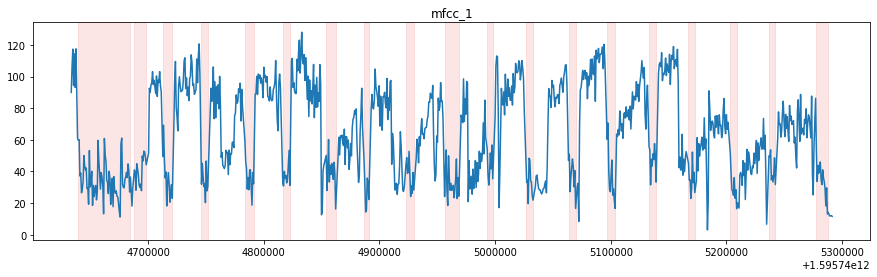

In [19]:
MFCC_DIVIDE_FACTOR = 1
MFCC_PART = 1
first_mfcc = 1
last_mfcc = 1

plotFeatureArray(MFCC_PART, MFCC_DIVIDE_FACTOR, first_mfcc, last_mfcc, FEATURES['MFCC'])

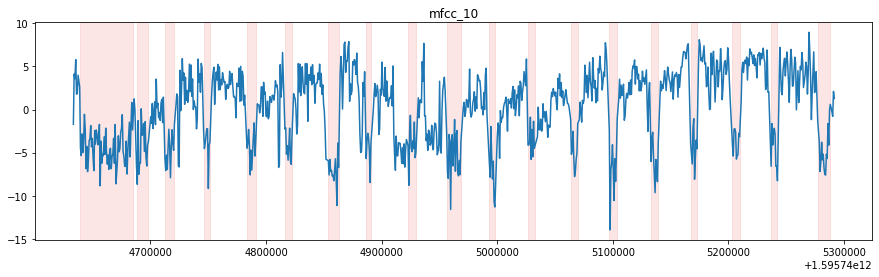

In [20]:
MFCC_DIVIDE_FACTOR = 1
MFCC_PART = 1
first_mfcc = 10
last_mfcc = 10

plotFeatureArray(MFCC_PART, MFCC_DIVIDE_FACTOR, first_mfcc, last_mfcc, FEATURES['MFCC'])

## Set up plot function for single-value feature

Ploting value of a feature and its different between value from previous sample.

Area shaded in pink shows when Chloe is speaking. Non-shaded area is when background music is playing.

In [21]:
# Plot feature value and its difference between neighboring values
def plotFeature(sub_part, divide_factor, feature, delta, feature_name):
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    time_split = np.array_split(time, divide_factor)
    label_split = np.array_split(label, divide_factor)

    feature_split = np.array_split(feature, divide_factor)
    delta_split = np.array_split(delta, divide_factor)

    # Plot feature values
    min_val = np.amin(feature_split[sub_part - 1])
    max_val = np.amax(feature_split[sub_part - 1])
    padding = get_padding(min_val, max_val)
    ylim_1 = [ (min_val - padding), (max_val + padding)]
    ax[0].set_title(feature_name)
    ax[0].set_ylim(ylim_1)
    ax[0].plot(time_split[sub_part - 1], feature_split[sub_part - 1], color='dodgerblue')
    ax[0].fill_between(
        time_split[sub_part - 1],
        ylim_1[0], ylim_1[1],
        where=label_split[sub_part - 1] == CLASS_TO_INT[CLASS_NAMES['CHLOE']],
        color='lightcoral', alpha=0.2)

    # Delta (max diff between current and previous 2 values)
    min_val = np.amin(delta_split[sub_part - 1])
    max_val = np.amax(delta_split[sub_part - 1])
    ylim_2 = [ min_val - padding, max_val + padding]
    ax[1].set_title('Delta ' + feature_name)
    ax[1].set_ylim(ylim_2)
    ax[1].plot(time_split[sub_part - 1], delta_split[sub_part - 1], color='darkorange')
    ax[1].fill_between(
        time_split[sub_part - 1],
        ylim_2[0], ylim_2[1],
        where=label_split[sub_part - 1] == CLASS_TO_INT[CLASS_NAMES['CHLOE']],
        color='lightcoral', alpha=0.2)

    # Show plot
    plt.show()

## Spectral Flatness

This seems to be the clearest among the single-value features. Variation of Chloe's voice causes variation in frequencies. Should be able to use just the value itself without the need to include delta values.

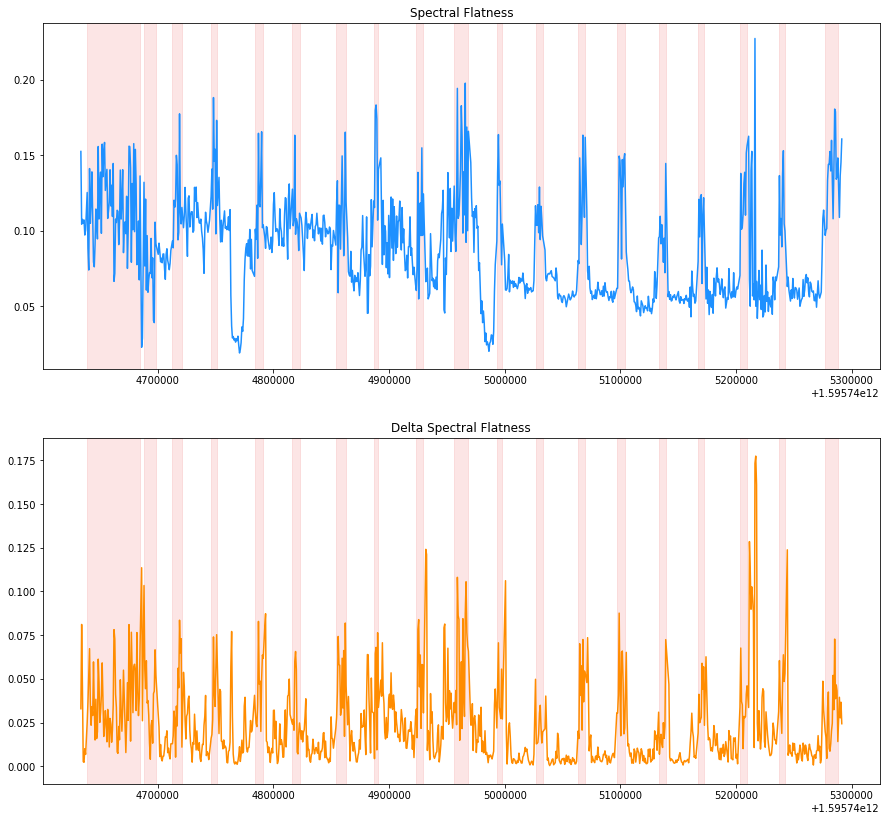

In [22]:
SP_FLATNESS_DIVIDE_FACTOR = 1
SP_FLATNESS_PART = 1
sp_flatness = df[FEATURES['SPECTRAL_FLATNESS']]
delta_sp_flatness = df[FEATURES['DELTA_SPECTRAL_FLATNESS']]

plotFeature(SP_FLATNESS_PART, SP_FLATNESS_DIVIDE_FACTOR, sp_flatness, delta_sp_flatness, 'Spectral Flatness')